# Segmenting and Clustering Neighborhoods 
## Part 1 - Obtaining the Data

In [29]:
import pandas as pd
import urllib.request as ur
from html_table_parser import HTMLTableParser # Source code: https://github.com/schmijos/html-table-parser-python3

In [30]:
nb = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

req = ur.Request(url=nb)
f = ur.urlopen(req)
xhtml = f.read().decode('utf-8')

p = HTMLTableParser()
p.feed(xhtml)

In [31]:
table_list = p.tables

nbhoods = pd.DataFrame.from_dict(table_list[0])
nbhoods.rename(columns={0:'Postcode',1:'Borough',2:'Neighborhood'}, inplace=True)
nbhoods.drop([0], axis=0, inplace=True)
nbhoods[0:5]

,Postcode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [32]:
nbhoods = nbhoods[nbhoods.Borough != 'Not assigned']
nbhoods[0:5]

,Postcode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights


In [33]:
nbhoods.loc[nbhoods['Neighborhood'] == 'Not assigned']

,Postcode,Borough,Neighborhood
9,M7A,Queen's Park,Not assigned


In [34]:
nbhoods = nbhoods.replace('Not assigned', 'Queen\'s Park')
nbhoods[0:8]

,Postcode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Queen's Park
11,M9A,Etobicoke,Islington Avenue


In [35]:
nbhoods = nbhoods.groupby(['Postcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
nbhoods[0:8]

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"


In [36]:
nbhoods.shape

(103, 3)

## Part 2 - The Latitude and the Longitude Coordinates of Each Neighborhood

In [37]:
cn = pd.read_csv('https://cocl.us/Geospatial_data')
cn.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [38]:
cn.rename(columns={'Postal Code':'Postcode'}, inplace=True)
cn.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [39]:
final = pd.merge(nbhoods, cn, on='Postcode', how='inner')
final[0:5]

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3 - Segmenting and Clustering the Neighborhoods in Toronto

In [48]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium
import json
import requests
from IPython.display import Image

We will first create a dataset that contains boroughs that have the word Toronto. 

In [41]:
toronto = final[final['Borough'].str.contains("Toronto")]
toronto[0:5]

,Postcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Creating a map of Toronto with its neighborhoods


In [47]:
latitude = 43.6532
longitude = -79.3832

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(final['Latitude'], final['Longitude'], final['Borough'], final['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

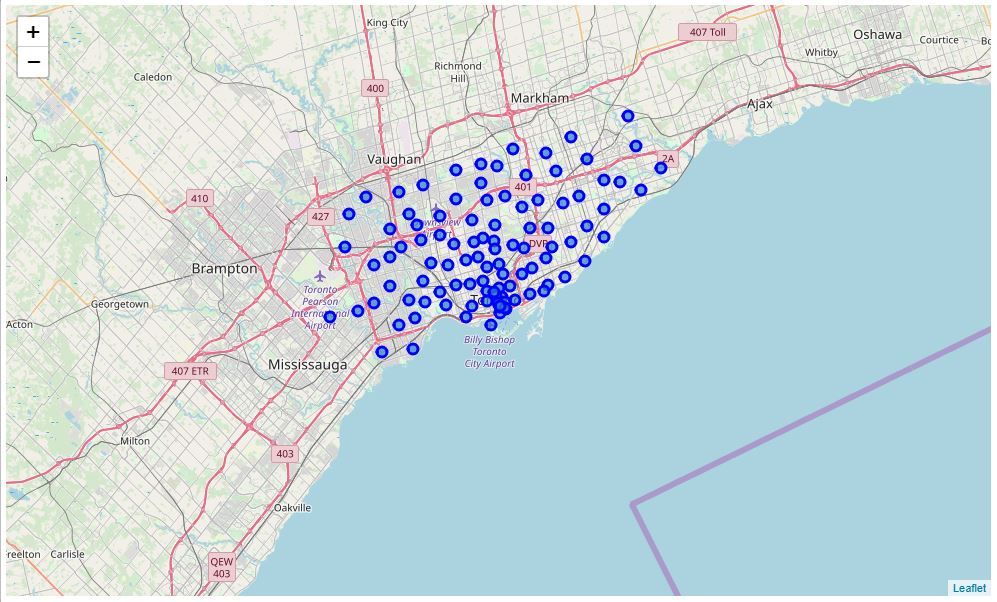

In [49]:
Image("map1.png")

### Exploring the neighborhoods of Toronto

We define a function to get the nearby venues.

In [23]:
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            '20180605', 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We create a new dataset by running the function above on each neighborhood. 

In [24]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

We check to see how many venues were returned by each neighborhood.

In [25]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,58,58,58,58,58,58
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,15,15,15,15,15,15
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",13,13,13,13,13,13
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",98,98,98,98,98,98
Christie,16,16,16,16,16,16


Let's find the number of unique venue categories.

In [27]:
len(toronto_venues['Venue Category'].unique())

235

### Analyzing each neighborhood

In [28]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

cols = list(toronto_onehot.columns.values)
cols.pop(cols.index('Neighborhood')) 
toronto_onehot = toronto_onehot[['Neighborhood']+cols]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we group the rows by neighborhood and we take the mean of the frequency of occurrence of each category.

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,...,0.00000,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.066667
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.076923,0.076923,0.076923,0.153846,0.153846,0.153846,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.000000,...,0.00000,0.00,0.011765,0.000000,0.000000,0.011765,0.000000,0.000000,0.00,0.011765
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.051020,0.000000,0.051020,0.010204,0.000000,0.000000,0.00,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.000000,...,0.00000,0.00,0.000000,0.011765,0.011765,0.000000,0.011765,0.011765,0.00,0.011765


We print each neighborhood along with the top 5 most common venues.

In [30]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.06
1             Café  0.05
2  Thai Restaurant  0.04
3       Steakhouse  0.04
4              Bar  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2              Bakery  0.03
3  Seafood Restaurant  0.03
4         Cheese Shop  0.03


----Brockton, Exhibition Place, Parkdale Village----
               venue  freq
0     Breakfast Spot  0.09
1        Coffee Shop  0.09
2               Café  0.09
3  Convenience Store  0.05
4         Restaurant  0.05


----Business Reply Mail Processing Centre 969 Eastern----
           venue  freq
0    Yoga Studio  0.07
1  Auto Workshop  0.07
2     Comic Shop  0.07
3           Park  0.07
4     Restaurant  0.07


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.15
1   Airport Service  0.15
2  Airport Termin

We create a new dataset that displays the top 10 venues for each neighborhood.

In [31]:
# Function that sorts the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Sushi Restaurant,Burger Joint,Bakery,Gym,Asian Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Café,Restaurant,Steakhouse,Bakery,Seafood Restaurant,Italian Restaurant,Cheese Shop,Farmers Market
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym,Italian Restaurant,Performing Arts Venue,Pet Store,Gym / Fitness Center,Nightclub,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Garden Center,Garden,Light Rail Station,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Plane,Sculpture Garden,Boat or Ferry,Airport Gate,Airport,Airport Food Court


### Clustering the neighbourhoods

We run *k*-means to cluster the neighborhoods into 6 clusters.

In [32]:
k = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

New dataset that includes the cluster column as well as the top 10 venues.

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Coffee Shop,Pub,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Pub
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Sandwich Place,Pet Store,Park,Board Shop,Brewery,Burger Joint,Burrito Place,Pub,Movie Theater,Sushi Restaurant
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Gastropub,Fish Market,Juice Bar,Bookstore,Latin American Restaurant
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


We will now visualize the resulting clusters.

In [42]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.7)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

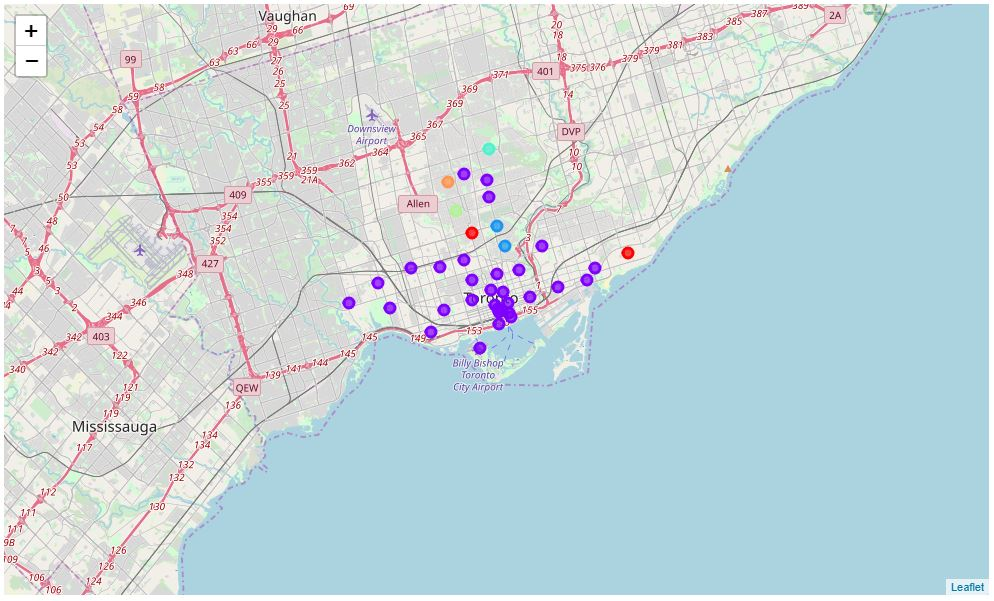

In [50]:
Image("map2.png")

From the map above we can see that a large number of neighborhoods are similar, while two pairs of neighborhoods and three individual neighborhoods are different from all the other neighborhoods.

### Examining the clusters

We examine the different clusters to see how they distinguish themselves from each other.

#### Cluster 1

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Health Food Store,Coffee Shop,Pub,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
49,Central Toronto,0,Coffee Shop,Pub,American Restaurant,Medical Center,Sports Bar,Supermarket,Sushi Restaurant,Bagel Shop,Fried Chicken Joint,Light Rail Station


#### Cluster 2

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Pub
42,East Toronto,1,Sandwich Place,Pet Store,Park,Board Shop,Brewery,Burger Joint,Burrito Place,Pub,Movie Theater,Sushi Restaurant
43,East Toronto,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Gastropub,Fish Market,Juice Bar,Bookstore,Latin American Restaurant
45,Central Toronto,1,Hotel,Clothing Store,Food & Drink Shop,Dance Studio,Burger Joint,Sandwich Place,Breakfast Spot,Park,Gym,Electronics Store
46,Central Toronto,1,Sporting Goods Shop,Coffee Shop,Yoga Studio,Gym / Fitness Center,Cosmetics Shop,Clothing Store,Chinese Restaurant,Dessert Shop,Diner,Salon / Barbershop
47,Central Toronto,1,Dessert Shop,Sandwich Place,Pizza Place,Italian Restaurant,Sushi Restaurant,Café,Thai Restaurant,Coffee Shop,Gym,Japanese Restaurant
51,Downtown Toronto,1,Coffee Shop,Restaurant,Café,Italian Restaurant,Pub,Bakery,Market,Pizza Place,Pet Store,Sandwich Place
52,Downtown Toronto,1,Japanese Restaurant,Coffee Shop,Gay Bar,Burger Joint,Sushi Restaurant,Restaurant,Pub,Bubble Tea Shop,Gastropub,Men's Store
53,Downtown Toronto,1,Coffee Shop,Café,Bakery,Pub,Park,Theater,Mexican Restaurant,Breakfast Spot,French Restaurant,Chocolate Shop
54,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Restaurant,Theater,Burger Joint,Italian Restaurant,Pizza Place,Japanese Restaurant


#### Cluster 3

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,2,Playground,Gym,Park,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
50,Downtown Toronto,2,Park,Playground,Trail,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


#### Cluster 4

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,3,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 5

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Central Toronto,4,Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


#### Cluster 6

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,5,Garden,Home Service,Ice Cream Shop,Yoga Studio,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
